# Lesson 7

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. Сделать обзорный анализ выбранного датасета
3. Обучить любой классификатор (какой вам нравится)
4. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для 5 случайных объектов из тестового набора

In [765]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

### Features
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [766]:
df = pd.read_csv('adult.data', names=['age', 'workclass','fnlwgt', 'education', 'education-num', 'marital-status',
                                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                                 'hours-per-week', 'native-country', 'target'])

In [767]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [768]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

In [769]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [770]:
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [771]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'native-country']

In [772]:
df['target'].value_counts()

 <=50K    24720
 >50K      7841
Name: target, dtype: int64

In [773]:
df['target'].where(df.target == ' >50K', 0, inplace=True)
df['target'].where(df.target == 0, 1, inplace=True)

In [774]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

In [775]:
df['target'] = df['target'].astype(int)

In [776]:
X = df.drop(columns='target')
y = df['target']

In [777]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [778]:
from lightgbm import LGBMClassifier

In [779]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator

In [780]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]
    
    
class CatSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
    
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col in self.columns:
            if col not in test_columns:
                X[col] = 0
        return X[self.columns]

In [781]:
final_transformers = []

for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', CatSelector(key=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for num_col in num_cols:
    num_transformer = Pipeline([
        ('selector', NumberSelector(key=num_col))
    ])
    
    final_transformers.append((num_col, num_transformer))

In [782]:
feats = FeatureUnion(final_transformers)

In [783]:
pipeline = Pipeline([
    ('features', feats)
])

In [784]:
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [785]:
names_cols = pd.get_dummies(df[cat_cols]).columns.to_list() + num_cols

In [786]:
X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=names_cols)

In [787]:
X_test = pd.DataFrame(pipeline.transform(X_test), columns=names_cols)

In [788]:
from sklearn.metrics import classification_report

In [789]:
from lightgbm import LGBMClassifier

In [790]:
model = LGBMClassifier(random_state=1, class_weight={1 : 1.3})

In [791]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [792]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      7417
           1       0.74      0.71      0.73      2352

    accuracy                           0.87      9769
   macro avg       0.82      0.82      0.82      9769
weighted avg       0.87      0.87      0.87      9769



In [793]:
import shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


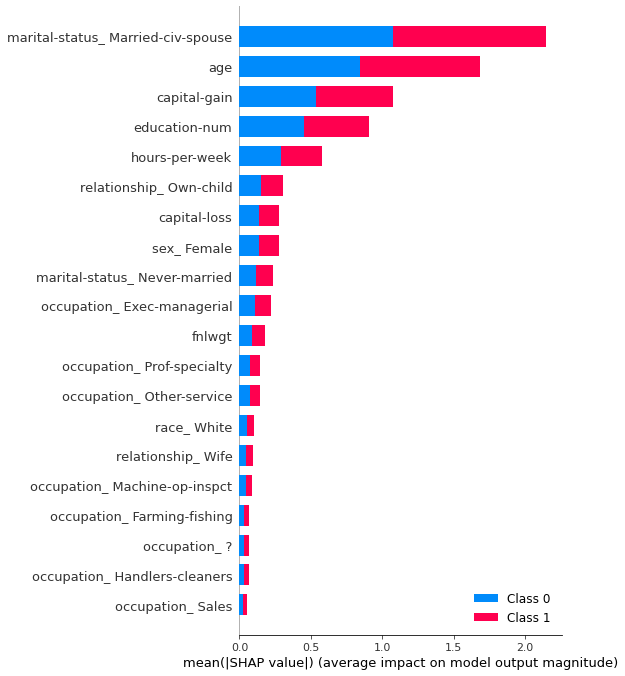

In [794]:
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

Из данного графика видно, что самый важный признак получается из преобразования категориального признака "семейное положение" с помощью OHEEncoding, а именно имеет ли объект супруга. Остальные важные признаки, в основном, числовые (возраст, прирост капитала и т д).

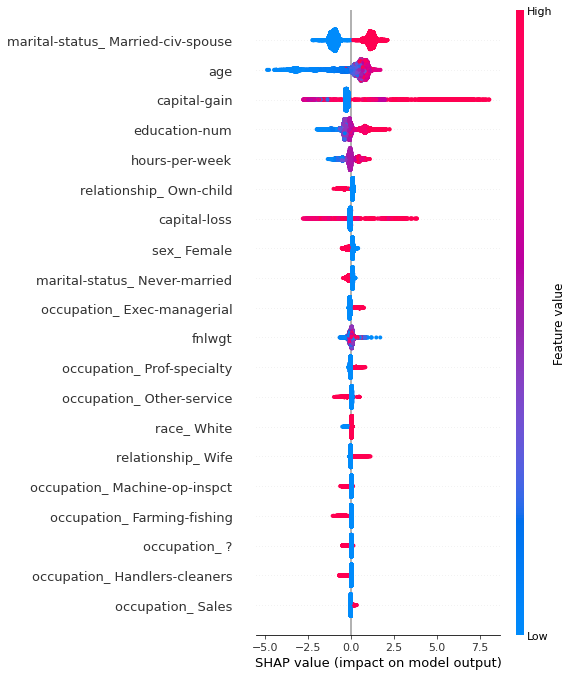

In [795]:
shap.summary_plot(shap_values_all[1], X_train)

Из графика следует, что вероятность стать классом '1' тем выше, чем выше возраст и доход объекта, а также важно состоит ли объект в браке (если да, то вероятность выше) и имеет ли объект собственных детей (если да, то вероятность понижается).

In [796]:
shap_values_all = explainer.shap_values(X_test)

# случайные индексы
idxs = X_test.sample(5).index.to_list()

shap.force_plot(explainer.expected_value[1], shap_values_all[1][idxs], X_test.iloc[idxs])

In [797]:
ds = [shap.force_plot(explainer.expected_value[1], shap_values_all[1][i], X_test.iloc[i]) for i in idxs]

In [798]:
ds[0]

In [799]:
ds[1]

In [800]:
ds[2]

In [801]:
ds[3]

In [802]:
ds[4]

In [803]:
y_pred = model.predict(X_test)
[(y_test.iloc[i], y_pred[i]) for i in idxs]

[(0, 0), (1, 1), (0, 0), (1, 1), (0, 0)]

в объектах с индексами 0 и 3 очень противоречивые признаки и с минимальными перевесами признаков получилось правильно предсказать модели (-0.08 и 0.20)